In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, loss_fn, VAE_Cheby_L3, VAE_Cheby_L3_sparse, VAE_Cheby3_kernel32, VAE_Cheby3_kernelDU
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

#from Cuda import DeviceDataLoader

In [75]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [76]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
IMAGE_CHANNELS = 1
RANK = 240
H_DIM = 200 

In [77]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [78]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [79]:
dataset1 = datasets.MNIST(root='data', train=True, download=True, transform=Compose([transforms.Resize(IMAGE_SIZE), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))


In [80]:
dataset1 = datasets.FashionMNIST(root='data', train=True, download=True, transform=Compose([transforms.Resize(IMAGE_SIZE), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [81]:
torch.manual_seed(0)

In [82]:
#train_ds, val_ds = random_split(dataset1, [50000, 10000])


In [83]:
train_loader = DataLoader(dataset1, BATCH_SIZE, shuffle=True)
#train_loader = DeviceDataLoader(train_loader, device)
#val_loader = DataLoader(val_ds, BATCH_SIZE)

In [84]:
for images,_ in train_loader:
    print(torch.min(images[0]))
    break


tensor(-1.)


In [85]:
#model = VAE_Cheby_L3(IMAGE_SIZE*IMAGE_SIZE, H_DIM, Z_DIM, RANK).to(device)
torch.cuda.empty_cache() 
model = VAE_Cheby3_kernel32(IMAGE_SIZE, H_DIM, Z_DIM).to(device)
#model = VAE_Cheby3_kernelDU(IMAGE_SIZE, H_DIM, Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#model = DeviceDataLoader(model, device)


In [86]:
num_param = []
for name, param in model.named_parameters():
    num = torch.count_nonzero(param)
    num_param.append(num)

torch.sum(torch.tensor(num_param))

tensor(441209)

In [87]:
model.encoder.mask.shape

torch.Size([245, 784])

In [88]:
list_of_losses = []
list_of_epochs =[]
for epoch in range(NUM_EPOCHS):
    for images, _ in train_loader: 
        images = images.reshape(-1, IMAGE_SIZE*IMAGE_SIZE)   
        recon_images, mu, logvar = model(images.to(device))
        loss, bce, kld = loss_fn(recon_images.to(device), denorm(images).to(device), mu.to(device), logvar.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                #epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #print(to_print)
    list_of_losses.append(loss)
    list_of_epochs.append(epoch + 1)
    print('loss', loss)
    print("Epoch : ", epoch + 1)

/home/ashish-razer/Programs/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss tensor(7791.4341, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  1
loss tensor(8360.8008, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  2
loss tensor(6964.9668, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  3
loss tensor(7612.9492, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  4
loss tensor(7415.3350, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  5


In [89]:
mask = model.encoder.mask
torch.count_nonzero(mask)

tensor(62720, device='cuda:0')

In [90]:
for images, _ in train_loader: 
    recon_images, mu, logvar = model(images.to(device))
    break

In [91]:
recon_images = recon_images.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

In [92]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

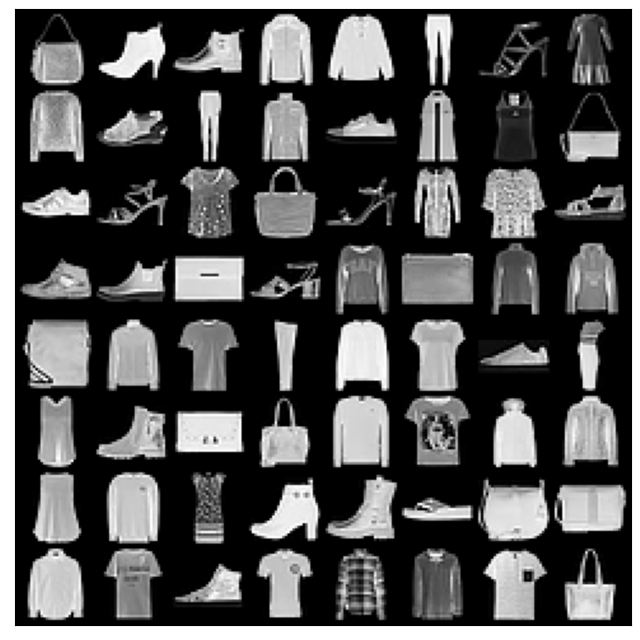

In [93]:
show_images(denorm(images))

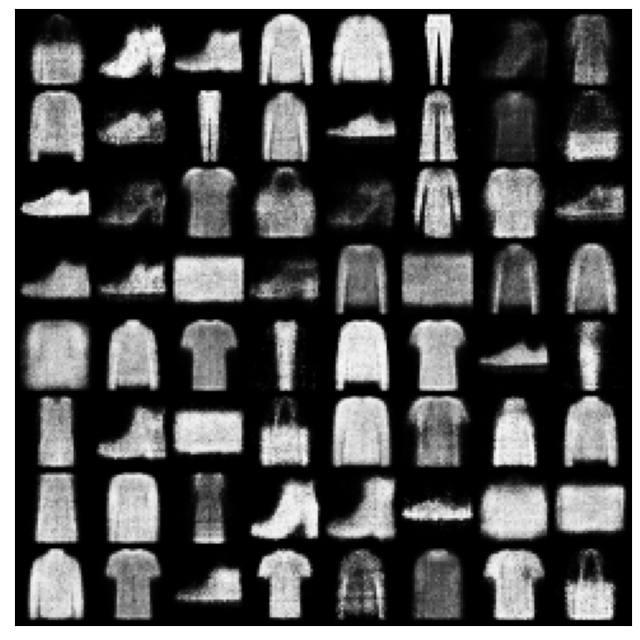

In [94]:
show_images(recon_images.to('cpu'))

In [95]:
list_of_losses = [i.detach().numpy() for i in list_of_losses ]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
my_dict = {
    "epochs": list_of_epochs, 
    "losses": list_of_losses
}

df = pd.DataFrame(my_dict)

In [ ]:
df.style

,epochs,losses
0,1,2145.8613
1,2,1768.5775
2,3,1435.9138
3,4,1297.2521
4,5,1160.3284


In [ ]:
num_param = []
for name, param in model.named_parameters():
    num = torch.count_nonzero(param)
    num_param.append(num)

In [ ]:
torch.sum(torch.tensor(num_param))

tensor(341857)